# __Criação do Mapa de Suscetibilidade com a rede ideal__
- Dataset: POA (cap. 4)

##### Copyright 2021 Caio Azevedo - ensaios de uma dissertação. 

13 de junho de 2021 - última atualização __todo santo dia__
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns

__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

In [1]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import plot

%matplotlib inline

In [2]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [3]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", "Input_POA.csv"))) #Input_POA  diabetes spc_data_landslides

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0


In [4]:
dataset.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
dataset = dataset[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0


In [5]:
dataset.shape

(100, 8)

In [6]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0
mean,16.93,201.71,84.49,1904.50,2532.15,7.52,-0.00,0.5
std,13.31,109.91,64.51,441.43,483.09,1.38,0.02,0.5
min,0.99,3.42,0.93,1210.00,1507.00,5.29,-0.05,0.0
25%,5.54,98.86,34.81,1420.00,2741.00,6.38,-0.02,0.0
50%,14.25,215.45,66.71,2230.00,2741.00,7.24,-0.00,0.5
75%,25.59,306.72,126.16,2230.00,2773.00,8.37,0.01,1.0
max,50.76,355.01,257.71,2300.00,2790.00,10.82,0.07,1.0


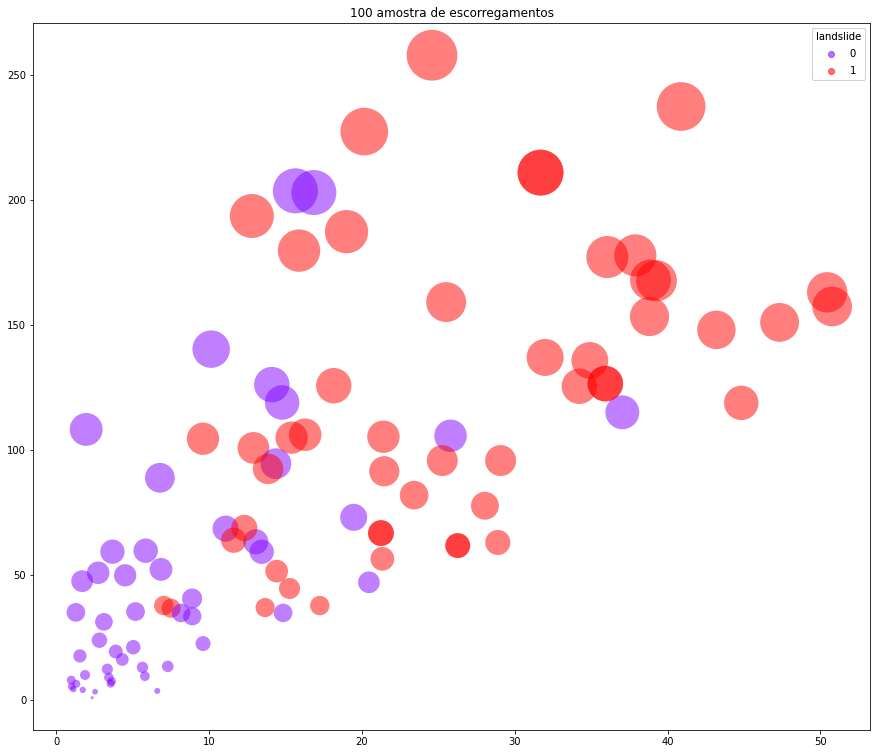

In [7]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.add_artist(legend1)
ax.title.set_text('100 amostra de escorregamentos') 

plt.show()

## Preparação dos dados (Remoção das features irrelevantes & Normalização)
__Cuidado com data leakage, considerar as melhores práticas:__
- Train-Test Evaluation With Correct Data Preparation
- Data Preparation With k-fold Cross-Validation

- ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref. https://www.section.io/engineering-education/data-leakage/
- ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1

 __Segue abaixo, a ordem de relevância das variáveis, bem como a identificação daquelas que podem ser removidas (vide analise análise da features).__
  - elevation | elevation (ok) 
  - uso_solo | uso_solo (ok)
  - twi | curvatura (ok)
  - curvatura | twi (ok)
  - lito | aspect   __(to be tested)__
  - aspect | lito   __(to be tested)__
  - slope | slope   __(to be tested)__

In [8]:
#features menos relevantes POA
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('curv',axis=1)
#dataset = dataset.drop('aspect',axis=1)

# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0


In [9]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    scaler.fit(X_test)
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [10]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.20
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=seed)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, random_state=seed)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    
    test_x = scaler.transform(test_x)
    # scale the test dataset
    
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [11]:
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [12]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)

In [13]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

64 train examples
16 validation examples
20 test examples


__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [14]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

## Rede Neural Customizada
### Força Bruta para tuning dos hiperparametros 
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

In [15]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size      

In [16]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [17]:
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate,input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, patience=10) 

    #camadad de entrada
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,weights_initializer=rna.glorot_uniform,reg_strength=1.0, reg_func=rna.l2_regularization))
 
    #camadad de saída
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_uniform))  

    return nn

In [18]:
neurons = [8,10]
hidden_layers = [2,3]
learning_rate = [0.001,0.01]
batch_size = [4,8,16]
dropout_rate = [0.1,0.25,0.5]

#for num_neurons_layers in neurons:
#    for num_hidden_layers in hidden_layers:
#        for num_learning_rate in learning_rate:
#            for num_batch_size in batch_size:
                 #print('Para camadas {} , neurônios: {}, learning rate: {}, batch size: {}'.format(num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size))


In [19]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, input_dim, output_dim)
                
                nn.fit(X_train, y_train, epochs=1501,batch_size=num_batch_size, verbose=1501)
                
                y_pred = nn.predict(X_test)
                accu = 100*accuracy_score(y_test, y_pred > 0.5)
                lst_hyperP.append( hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size) )
                lst_ANN.append(ANN_accuracy(accu,nn))
                print('Para {} neurônios, {} camadas,  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate, num_batch_size,accu))

epoch:    0/1501 loss_train: 0.85074090 + 0.11025789 = 0.96099878 loss_val = 0.85074090
epoch: 1501/1501 loss_train: 0.34688858 + 0.00589850 = 0.35278709 loss_val = 0.34688858
Para 8 neurônios, 2 camadas,  0.001 learning rate, 4 batch size, temos:  Acurácia: 80.00% 
epoch:    0/1501 loss_train: 1.21521298 + 0.12181815 = 1.33703113 loss_val = 1.21521298
epoch: 1501/1501 loss_train: 0.33680736 + 0.01862261 = 0.35542997 loss_val = 0.33680736
Para 8 neurônios, 2 camadas,  0.001 learning rate, 8 batch size, temos:  Acurácia: 80.00% 
epoch:    0/1501 loss_train: 1.73914463 + 0.12514439 = 1.86428902 loss_val = 1.73914463
epoch: 1501/1501 loss_train: 0.37525398 + 0.06760742 = 0.44286140 loss_val = 0.37525398
Para 8 neurônios, 2 camadas,  0.001 learning rate, 16 batch size, temos:  Acurácia: 85.00% 
epoch:    0/1501 loss_train: 0.85610966 + 0.11235694 = 0.96846660 loss_val = 0.85610966
epoch: 1501/1501 loss_train: 0.30050644 + 0.00282553 = 0.30333197 loss_val = 0.30050644
Para 8 neurônios, 2 ca

In [20]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

85.00% foi a melhor acurácia, obtida com 2 camadas,8 neurônios, 0.001 de learning rate e 16 de batch size!


In [21]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann.acuracia,best_ann.ann))

85.00% foi a melhor acurácia, obtida com a rede <Rede_Neural.NeuralNetwork object at 0x00000263EA609A90> 


# Avaliação da rede Proprietária

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [23]:
def NetworkPerformance(y_teste, yhat_class):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_teste, yhat_class)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_teste, yhat_class)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_teste, yhat_class)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_teste, yhat_classes)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_teste, yhat_class)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_teste, yhat_class)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_teste, yhat_class)
    print(matrix)

Primeira abordagem, recuperar a melhor configuração de rede da otimização por força bruta

In [24]:
bestNN = best_ann.ann

Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [25]:
#bestNN = setBestNeuralNetwork(best_hyper.camadas,best_hyper.neuronios,best_hyper.learning_rate,input_dim, output_dim)
#bestNN.fit(X_train, y_train, epochs=1501,batch_size=num_batch_size, verbose=1501)
#bestNN

In [26]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 85.00%


In [27]:
NetworkPerformance(y_test, yhat_classes)

Accuracy: 0.850000
Precision: 0.750000
Recall: 0.600000
F1 score: 0.666667
Cohens kappa: 0.571429
ROC AUC: 0.766667
[[14  1]
 [ 2  3]]


__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [28]:
if accu >= 90:
    print('ótima acurácia, rede salva!')
    bestNN.save('bestANN\suscetibilidadeNN_poa.pkl')
else:
    print('acurácia abaixo de .9')

acurácia abaixo de .9


In [29]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

Acurácia: 93.75%


In [30]:
NetworkPerformance(y_val, yhat_classes)

Accuracy: 0.937500
Precision: 1.000000
Recall: 0.900000
F1 score: 0.947368
Cohens kappa: 0.870968
ROC AUC: 0.950000
[[6 0]
 [1 9]]


Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [31]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [32]:
X = dataset.drop('class',axis=1)
y= dataset['class']
X = X.to_numpy()    #converts dataframe into array to be used at NN
y = y.to_numpy()    #converts dataframe into array to be used at NN
y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
minmax = MinMaxScaler(feature_range=(-1, 1))
X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [1. 1. 1. 1. 1. 1. 1.]


In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train.shape, y_train.shape)
    
    yhat_probs = bestNN.predict(X_test)
    lst_accu_stratified.append(100*accuracy_score(y_test, yhat_probs > 0.5))

Numero de Splits de X:  10 

(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)
(80, 7) (80, 1)


In [34]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [85.0, 95.0, 70.0, 80.0, 85.0, 70.0, 75.0, 90.0, 80.0, 100.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 70.0 %

Acurácia média: 83.0 %

Desvio Padrão: 10.055402085998905


Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [35]:
nn = None
nn

In [36]:
#nn = NeuralNetwork.load('bestANN\suscetibilidadeNN_poa.pkl')
nn = bestNN

In [37]:
y_pred = nn.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 100.00%


In [38]:
y_pred = nn.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia: 78.75%


In [39]:
y_pred = nn.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia: 93.75%


In [40]:
dataset

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0
...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0


In [41]:
y_pred = nn.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

Acurácia: 83.00%


In [42]:
NetworkPerformance(y, yhat_classes)

Accuracy: 0.830000
Precision: 0.851064
Recall: 0.800000
F1 score: 0.824742
Cohens kappa: 0.660000
ROC AUC: 0.830000
[[43  7]
 [10 40]]


In [43]:
output_proprietario

,slope,aspect,elevation,uso_solo,lito,twi,curv,class,score
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0,0.593996
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0,0.574419
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0,0.140742
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0,0.100414
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0,0.182510
...,...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1,0.903362
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1,0.126433
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1,0.557152
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0,0.250743


ROC AUC=0.936


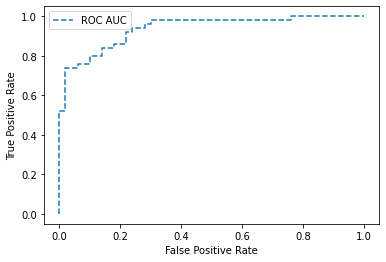

In [44]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

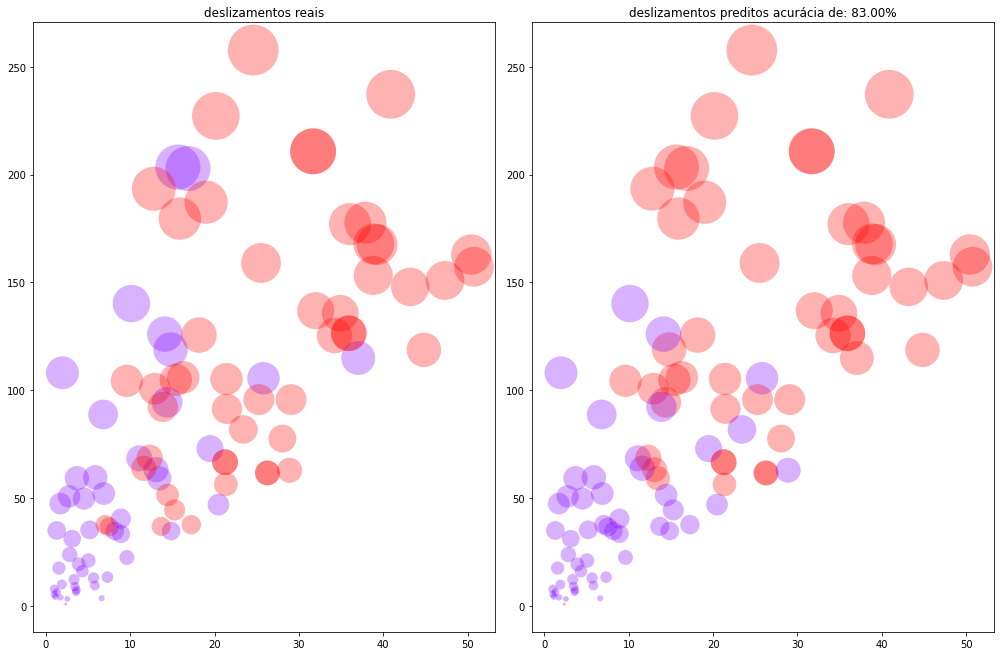

In [45]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


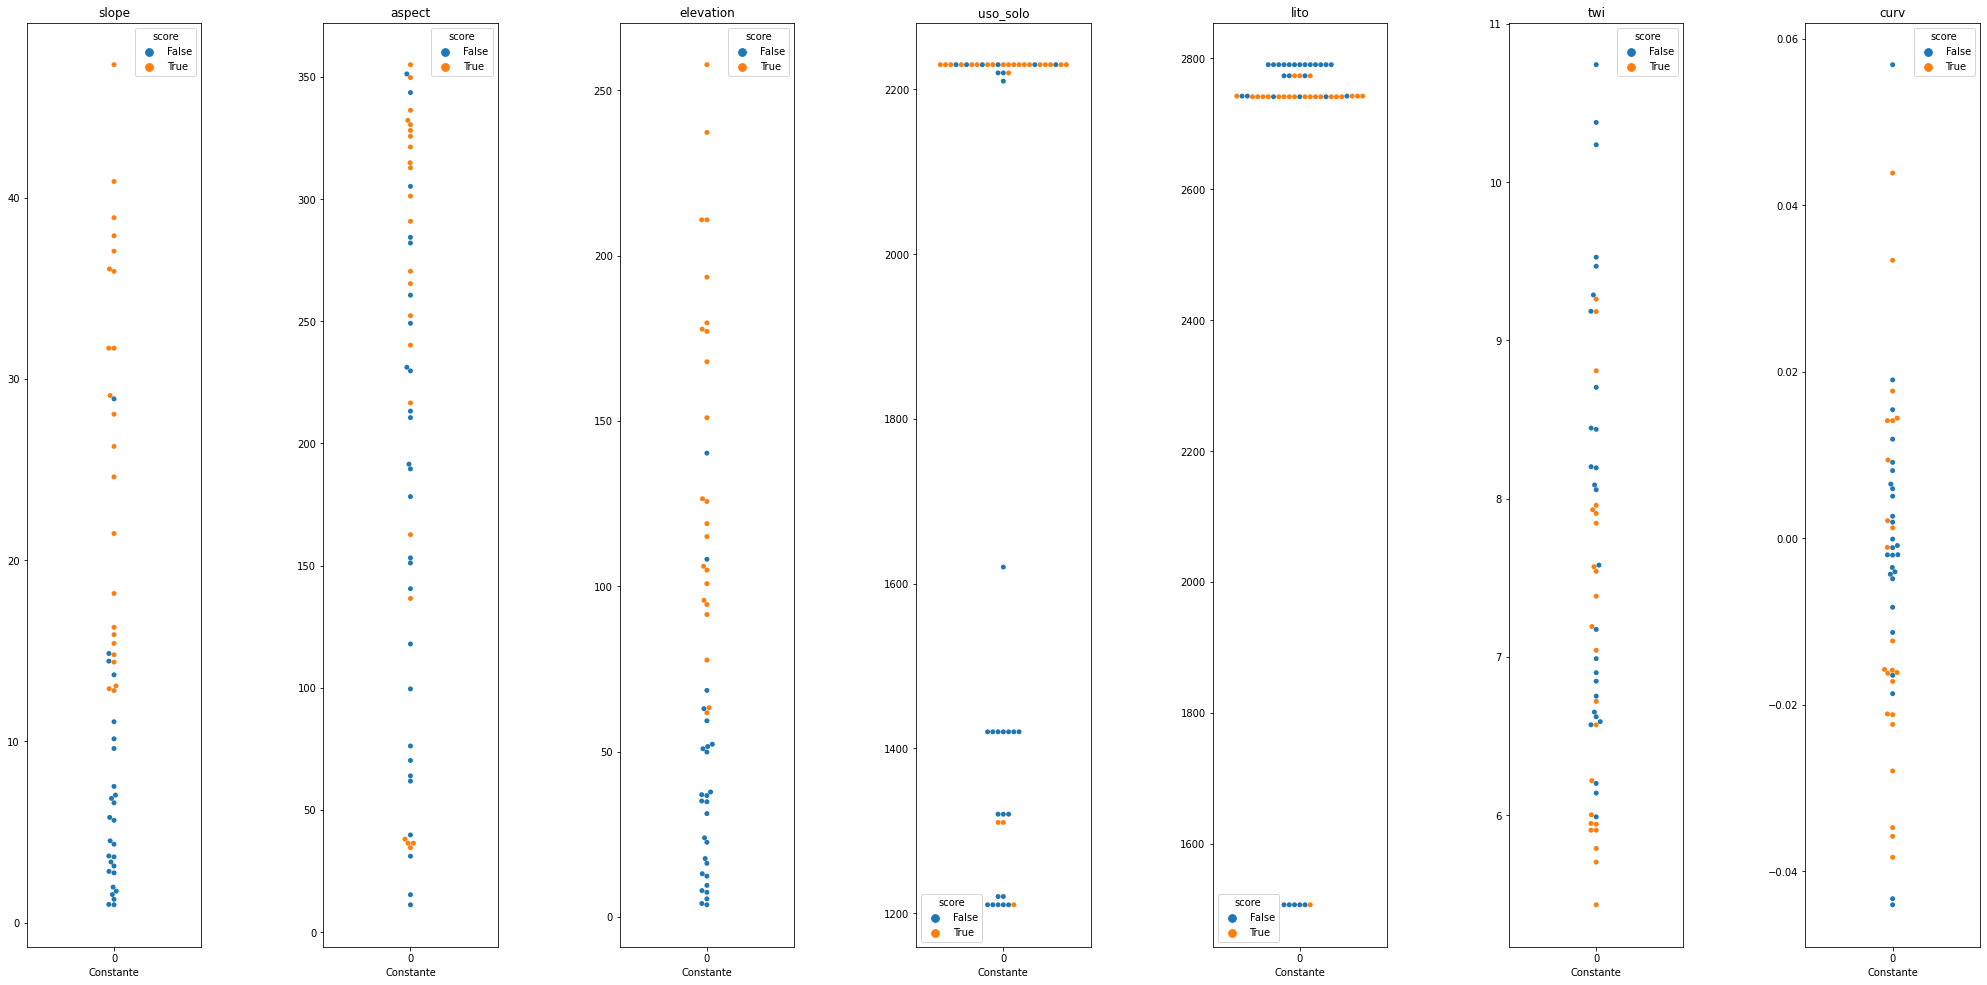

In [46]:
output_proprietario
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('score',axis=1) 
plotSwarmChart(dataSet)

In [47]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

## Rede Neural  Keras
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [48]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [49]:
#HyperParameters: {'num_hidden_layers': 3, 'num_units': 10, 'dropout_rate': 0.1, 'learning_rate': 0.004393067702361967
#opt = keras.optimizers.Adam(learning_rate=0.0001)
#model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
#model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=metrics)               

In [50]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [51]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(12, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(12, activation='relu'))
hypermodel.add(Dropout(0.2821478566400208))
hypermodel.add(Dense(12, activation='relu'))
hypermodel.add(Dropout(0.2821478566400208))

hypermodel.add(Dense(1, activation='sigmoid'))
hypermodel.compile(optimizer=keras.optimizers.Adam(0.006549533067877217), loss="binary_crossentropy", metrics=['accuracy'])

In [52]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
16/16 [==============================] - 0s 729us/step - loss: 0.6842 - accuracy: 0.5125
Epoch 2/500
16/16 [==============================] - 0s 665us/step - loss: 0.6677 - accuracy: 0.6500
Epoch 3/500
16/16 [==============================] - 0s 663us/step - loss: 0.6794 - accuracy: 0.5625
Epoch 4/500
16/16 [==============================] - 0s 731us/step - loss: 0.5967 - accuracy: 0.7375
Epoch 5/500
16/16 [==============================] - 0s 731us/step - loss: 0.4973 - accuracy: 0.8375
Epoch 6/500
16/16 [==============================] - 0s 798us/step - loss: 0.4581 - accuracy: 0.8250
Epoch 7/500
16/16 [==============================] - 0s 864us/step - loss: 0.4509 - accuracy: 0.7625
Epoch 8/500
16/16 [==============================] - 0s 731us/step - loss: 0.4315 - accuracy: 0.8375
Epoch 9/500
16/16 [==============================] - 0s 731us/step - loss: 0.4347 - accuracy: 0.8875
Epoch 10/500
16/16 [==============================] - 0s 798us/step - loss: 0.3467 - accura

16/16 [==============================] - 0s 798us/step - loss: 0.0635 - accuracy: 0.9875
Epoch 160/500
16/16 [==============================] - 0s 731us/step - loss: 0.0417 - accuracy: 0.9875
Epoch 161/500
16/16 [==============================] - 0s 665us/step - loss: 0.0543 - accuracy: 0.9750
Epoch 162/500
16/16 [==============================] - 0s 665us/step - loss: 0.0617 - accuracy: 0.9625
Epoch 163/500
16/16 [==============================] - ETA: 0s - loss: 3.4647e-04 - accuracy: 1.00 - 0s 598us/step - loss: 0.0434 - accuracy: 0.9625
Epoch 164/500
16/16 [==============================] - 0s 731us/step - loss: 0.0228 - accuracy: 1.0000
Epoch 165/500
16/16 [==============================] - 0s 798us/step - loss: 0.0255 - accuracy: 1.0000
Epoch 166/500
16/16 [==============================] - 0s 731us/step - loss: 0.0972 - accuracy: 0.9750
Epoch 167/500
16/16 [==============================] - 0s 665us/step - loss: 0.2202 - accuracy: 0.9250
Epoch 168/500
16/16 [====================

16/16 [==============================] - 0s 731us/step - loss: 0.0108 - accuracy: 1.0000
Epoch 318/500
16/16 [==============================] - 0s 731us/step - loss: 0.0323 - accuracy: 0.9875
Epoch 319/500
16/16 [==============================] - 0s 731us/step - loss: 0.3794 - accuracy: 0.9250
Epoch 320/500
16/16 [==============================] - 0s 731us/step - loss: 0.1433 - accuracy: 0.9625
Epoch 321/500
16/16 [==============================] - 0s 665us/step - loss: 0.0524 - accuracy: 0.9750
Epoch 322/500
16/16 [==============================] - 0s 731us/step - loss: 0.0389 - accuracy: 0.9875
Epoch 323/500
16/16 [==============================] - 0s 731us/step - loss: 0.0422 - accuracy: 1.0000
Epoch 324/500
16/16 [==============================] - 0s 798us/step - loss: 0.0407 - accuracy: 0.9875
Epoch 325/500
16/16 [==============================] - 0s 665us/step - loss: 0.0335 - accuracy: 0.9875
Epoch 326/500
16/16 [==============================] - 0s 798us/step - loss: 0.0374 - a

16/16 [==============================] - 0s 731us/step - loss: 0.0298 - accuracy: 0.9875
Epoch 475/500
16/16 [==============================] - 0s 798us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 476/500
16/16 [==============================] - 0s 798us/step - loss: 0.0360 - accuracy: 0.9875
Epoch 477/500
16/16 [==============================] - 0s 731us/step - loss: 0.0462 - accuracy: 0.9750
Epoch 478/500
16/16 [==============================] - 0s 731us/step - loss: 0.0477 - accuracy: 0.9875
Epoch 479/500
16/16 [==============================] - 0s 731us/step - loss: 0.0114 - accuracy: 1.0000
Epoch 480/500
16/16 [==============================] - 0s 731us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 481/500
16/16 [==============================] - 0s 731us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 482/500
16/16 [==============================] - 0s 731us/step - loss: 9.3295e-04 - accuracy: 1.0000
Epoch 483/500
16/16 [==============================] - 0s 731us/step - loss: 0.0267

In [53]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 130


In [54]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 134ms/step - loss: 0.8648 - accuracy: 0.9000
Accuracy: 90.00


In [55]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/130
3/3 [==============================] - 0s 2ms/step - loss: 0.0273 - accuracy: 1.0000
Epoch 2/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0168 - accuracy: 1.0000
Epoch 3/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0230 - accuracy: 0.9875
Epoch 4/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0208 - accuracy: 0.9875
Epoch 5/130
3/3 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9875
Epoch 6/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0183 - accuracy: 0.9875
Epoch 7/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 8/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 9/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0113 - accuracy: 1.0000
Epoch 10/130
3/3 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 11/130
3/3 [===========

In [56]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 15ms/step - loss: 1.1614 - accuracy: 0.9500
Accuracy: 95.00


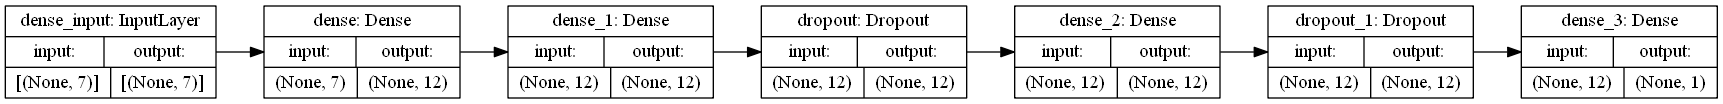

In [57]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

# Avaliação da rede keras

In [58]:
X = dataset.drop('class',axis=1)
y = dataset['class']
X = X.to_numpy()    #converts dataframe into array to be used at NN
y = y.to_numpy()    #converts dataframe into array to be used at NN
y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
minmax = MinMaxScaler(feature_range=(-1, 1))
X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [1. 1. 1. 1. 1. 1. 1.]


In [59]:
X

array([[-4.99371427e-01, -2.96773398e-01, -5.45953852e-01,
         8.71559633e-01,  9.23616524e-01, -6.07425959e-01,
        -1.41007743e-02],
       [-4.10791756e-01, -3.89770872e-01,  5.77777760e-01,
        -7.98165138e-01,  9.23616524e-01, -9.32965221e-01,
         9.93522321e-01],
       [-9.63778497e-01,  2.06254050e-01, -9.29340432e-01,
         6.51376147e-01,  1.00000000e+00,  9.17206322e-01,
        -5.27726944e-01],
       [-9.99091298e-01, -7.93250305e-01, -9.64796616e-01,
        -2.47706422e-01,  1.00000000e+00,  9.70439572e-01,
        -2.34202534e-01],
       [-5.94288206e-01, -5.44225444e-03, -4.73853849e-01,
        -1.00000000e+00,  9.25175370e-01, -1.72547756e-01,
        -1.87450134e-01],
       [-5.14988762e-01,  7.71683311e-01, -5.14691227e-01,
         8.71559633e-01,  9.23616524e-01, -5.45245986e-02,
        -3.90354488e-01],
       [ 2.45543372e-01,  8.32387136e-01,  5.92627729e-02,
         8.71559633e-01,  9.23616524e-01, -4.58038584e-01,
        -2.5536686

In [60]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train.shape, y_train.shape)
    
    yhat_probs = hypermodel.predict(X_test)
    lst_accu_stratified.append(100*accuracy_score(y_test, yhat_probs > 0.5))

Numero de Splits de X:  10 



In [61]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Lista de acurácias obtidas: [100.0, 100.0, 100.0, 95.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0]

Acurácia máxima obtida: 100.0 %

Acurácia mínima: 95.0 %

Acurácia média: 99.0 %

Desvio Padrão: 2.1081851067789197


In [62]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

Acurácia: 95.00%


In [63]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

Acurácia: 100.00%


In [64]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

Acurácia: 100.00%


In [65]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

Acurácia: 99.00%


In [66]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

,slope,aspect,elevation,uso_solo,lito,twi,curv,class,score
0,13.452180,127.04240,59.22540,2230,2741,6.376712,0.008905,0,2.439320e-04
1,15.656500,110.69380,203.50100,1320,2741,5.476123,0.065837,0,8.627846e-15
2,1.895332,215.47270,10.00250,2110,2790,10.594538,-0.020116,0,1.281480e-17
3,1.016567,39.76366,5.45029,1620,2790,10.741805,-0.003531,0,2.918091e-24
4,11.090160,178.25730,68.48230,1210,2742,7.579783,-0.000890,0,2.732462e-12
...,...,...,...,...,...,...,...,...,...
95,37.890990,336.34500,177.72200,2230,2773,6.217178,-0.021211,1,1.000000e+00
96,7.045130,99.54131,37.76530,1420,2742,9.468263,-0.018692,1,9.999605e-01
97,16.295700,216.57440,106.03300,2230,2773,9.182029,-0.015873,1,9.999892e-01
98,3.906067,50.09582,19.37700,2210,1507,7.014249,-0.000092,0,5.539373e-12


ROC AUC=0.988


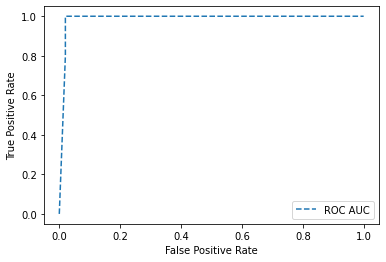

In [67]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

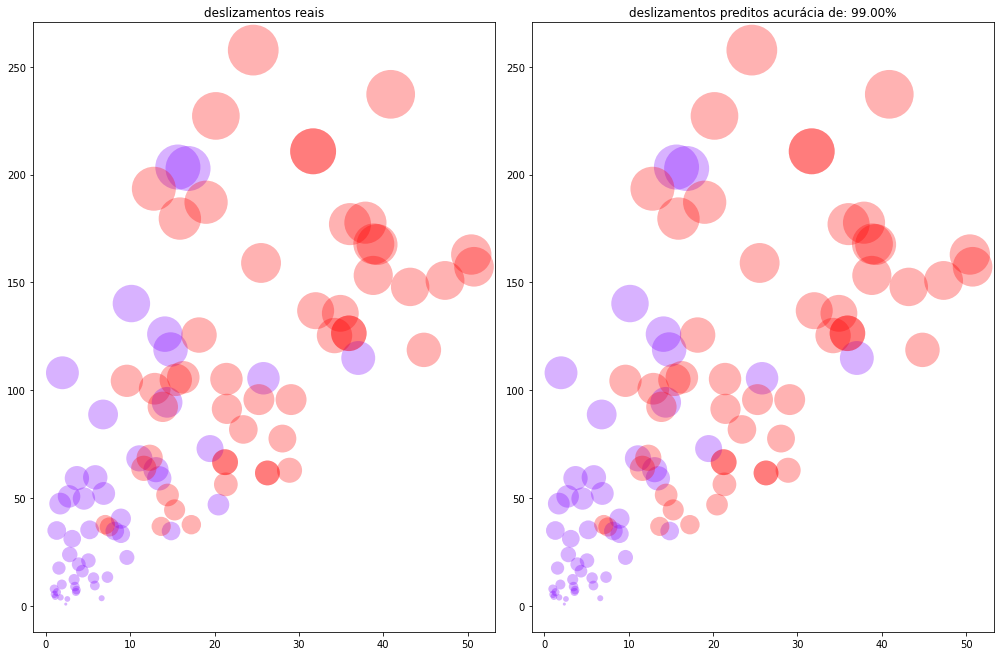

In [68]:
sizes = output_keras['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_keras['slope'], output_keras['elevation'],
            c=(output_keras['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

axes[1].scatter(output_keras['slope'], output_keras['elevation'],
            c=(output_keras['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try swarmplot
  warnings.warn(msg, UserWarning)
C:\Caio\Miniconda3\envs\cashme\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


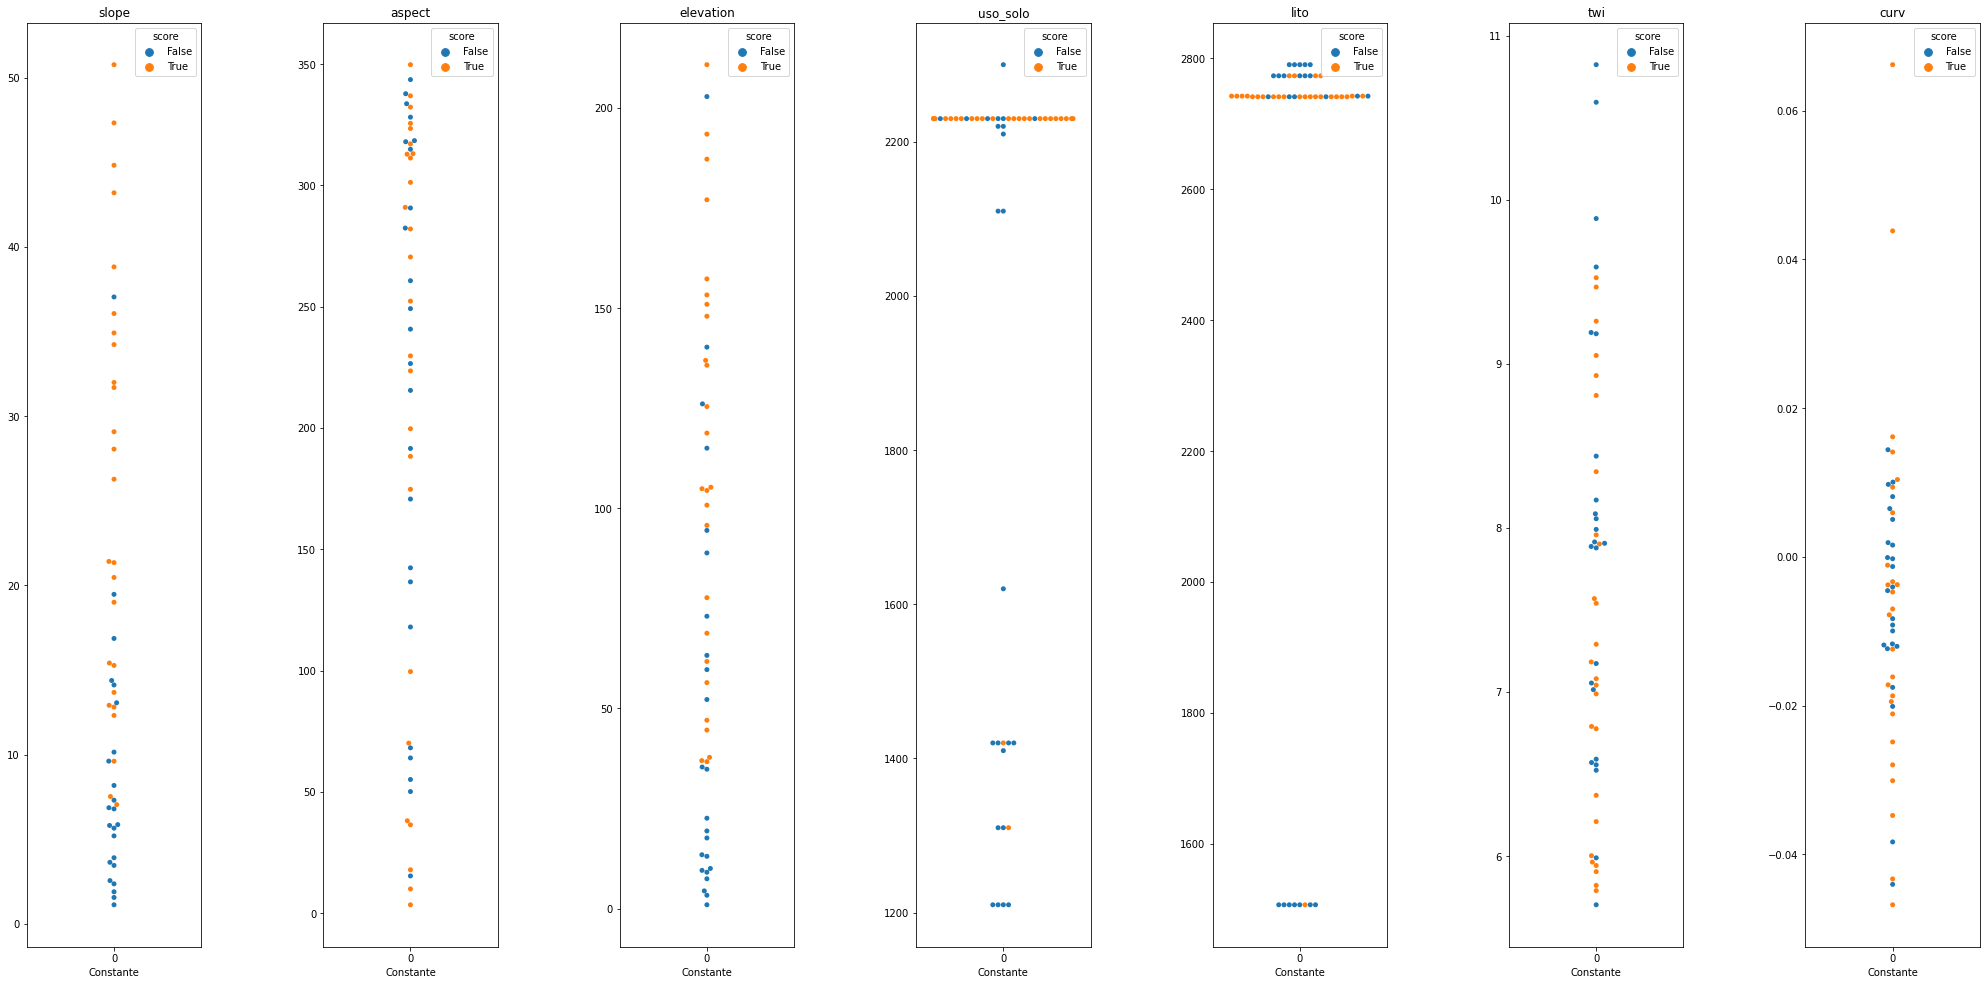

In [69]:
output_keras
dataSet = output_keras.sample(n = 50)
dataSet.drop('score',axis=1) 
plotSwarmChart(dataSet)